In [13]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [14]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

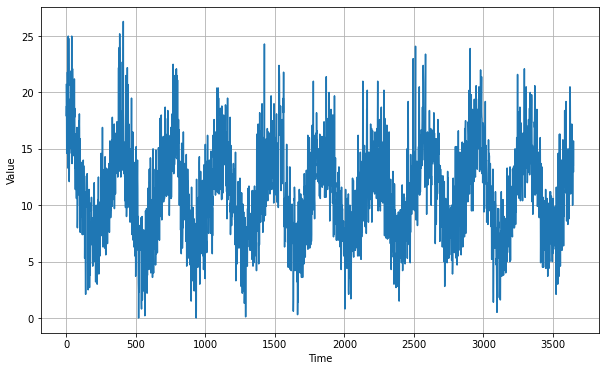

In [15]:
import csv
time_step = []
temps = []

with open('C:\\Users\\HP\\daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [16]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [23]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
tf.keras.backend.clear_session()
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 4s 395ms/step - loss: 13.4071 - mae: 13.9060
Epoch 2/100
10/10 [==============================] - 1s 105ms/step - loss: 13.0487 - mae: 13.5656
Epoch 3/100
10/10 [==============================] - 1s 104ms/step - loss: 12.5482 - mae: 13.0789
Epoch 4/100
10/10 [==============================] - 1s 104ms/step - loss: 12.0229 - mae: 12.5255
Epoch 5/100
10/10 [==============================] - 1s 103ms/step - loss: 11.4809 - mae: 11.9780
Epoch 6/100
10/10 [==============================] - 1s 124ms/step - loss: 10.9439 - mae: 11.4432
Epoch 7/100
10/10 [==============================] - 1s 107ms/step - loss: 10.4344 - mae: 10.9156
Epoch 8/100
10/10 [==============================] - 1s 102ms/step - loss: 9.9256 - mae: 10.3823
Epoch 9/100
10/10 [==============================] - 1s 96ms/step - loss: 9.3680 - mae: 9.8490
Epoch 10/100
10/10 [

10/10 [==============================] - 1s 100ms/step - loss: 9.4295 - mae: 9.9805
Epoch 84/100
10/10 [==============================] - 1s 100ms/step - loss: 11.7242 - mae: 12.2727
Epoch 85/100
10/10 [==============================] - 1s 103ms/step - loss: 13.3591 - mae: 13.5591
Epoch 86/100
10/10 [==============================] - 1s 100ms/step - loss: 11.3551 - mae: 12.0746
Epoch 87/100
10/10 [==============================] - 1s 100ms/step - loss: 16.6922 - mae: 17.4197
Epoch 88/100
10/10 [==============================] - 1s 100ms/step - loss: 17.7386 - mae: 18.6997
Epoch 89/100
10/10 [==============================] - 1s 104ms/step - loss: 23.1854 - mae: 22.8278
Epoch 90/100
10/10 [==============================] - 1s 101ms/step - loss: 30.8595 - mae: 32.0035
Epoch 91/100
10/10 [==============================] - 1s 100ms/step - loss: 26.2273 - mae: 26.9388
Epoch 92/100
10/10 [==============================] - 1s 100ms/step - loss: 27.6865 - mae: 29.1101
Epoch 93/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

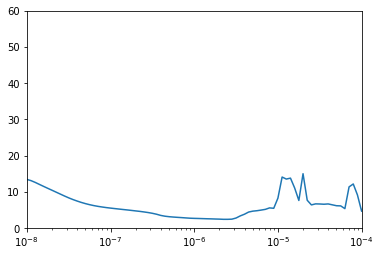

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [20]:
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 4s 166ms/step - loss: 9.0296 - mae: 9.6367
Epoch 2/150
25/25 [==============================] - 1s 44ms/step - loss: 3.0260 - mae: 3.5015
Epoch 3/150
25/25 [==============================] - 1s 44ms/step - loss: 2.4580 - mae: 2.9178
Epoch 4/150
25/25 [==============================] - 1s 48ms/step - loss: 2.1110 - mae: 2.5704
Epoch 5/150
25/25 [==============================] - 1s 45ms/step - loss: 1.9781 - mae: 2.4364
Epoch 6/150
25/25 [==============================] - 1s 45ms/step - loss: 1.9742 - mae: 2.4322: 0s - loss: 2.1176 - mae:
Epoch 7/150
25/25 [==============================] - 1s 45ms/step - loss: 1.7934 - mae: 2.2455
Epoch 8/150
25/25 [==============================] - 1s 44ms/step - loss: 1.8336 - mae: 2.2886
Epoch 9/150
25/25 [==============================] - 1s 46ms/step - loss: 1.8623 - mae: 2.3186
Epoch 10/150
25/25 [==============================] - 1s 47ms/step - loss: 1.8864 - mae: 2.3433
Epoch 11/150
25/25 [==

25/25 [==============================] - 2s 61ms/step - loss: 1.5236 - mae: 1.9670
Epoch 82/150
25/25 [==============================] - 2s 61ms/step - loss: 1.5192 - mae: 1.9643
Epoch 83/150
25/25 [==============================] - 2s 61ms/step - loss: 1.5045 - mae: 1.9461
Epoch 84/150
25/25 [==============================] - 2s 70ms/step - loss: 1.5072 - mae: 1.9504
Epoch 85/150
25/25 [==============================] - 2s 72ms/step - loss: 1.5036 - mae: 1.9423
Epoch 86/150
25/25 [==============================] - 2s 67ms/step - loss: 1.5102 - mae: 1.9526
Epoch 87/150
25/25 [==============================] - 2s 65ms/step - loss: 1.5104 - mae: 1.9534
Epoch 88/150
25/25 [==============================] - 2s 63ms/step - loss: 1.5053 - mae: 1.9449
Epoch 89/150
25/25 [==============================] - 2s 66ms/step - loss: 1.5440 - mae: 1.9900
Epoch 90/150
25/25 [==============================] - 1s 59ms/step - loss: 1.5240 - mae: 1.9679
Epoch 91/150
25/25 [==============================] -

In [24]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

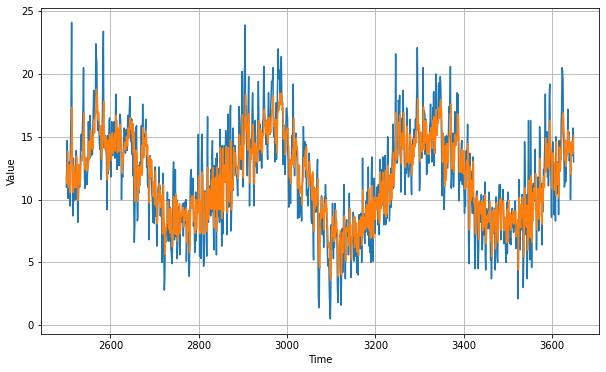

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7822711